In [1]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Ruta al archivo ZIP
zip_path = 'face_dataset.zip'
extract_dir = 'face_dataset'

# Extraer el contenido del ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Directorios para las carpetas de entrenamiento y prueba
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'test')

# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(image_dir, target_size=(128, 128)):
    images = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=target_size)  # Escala de grises y cambiar tamaño
            img_array = img_to_array(img) / 255.0  # Convertir a array y normalizar
            images.append(img_array)

    return np.array(images)

# Cargar y preprocesar las imágenes de entrenamiento y prueba
X_train = load_and_preprocess_images(train_dir)
X_test = load_and_preprocess_images(test_dir)

# Aplanar las imágenes para los autoencoders
X_train = X_train.reshape((X_train.shape[0], 128 * 128))
X_test = X_test.reshape((X_test.shape[0], 128 * 128))

# Imprimir las formas de X_train y X_test para confirmar
print("Nueva forma de X_train:", X_train.shape)  # Debe ser (num_images, 16384)
print("Nueva forma de X_test:", X_test.shape)    # Debe ser (num_images, 16384)

Nueva forma de X_train: (200, 16384)
Nueva forma de X_test: (12, 16384)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l1
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

# Funciones de carga y preprocesamiento de datos
def load_and_preprocess_data(train_csv_path, test_csv_path):
    """Carga y preprocesa los datos de los archivos CSV"""
    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)

    # Crear LabelEncoder para las emociones
    label_encoder = LabelEncoder()
    train_df['emotion_encoded'] = label_encoder.fit_transform(train_df['emotion'])
    test_df['emotion_encoded'] = label_encoder.transform(test_df['emotion'])

    return train_df, test_df, label_encoder

def load_images_from_paths(df, target_size=(128, 128)):
    """Carga y preprocesa las imágenes desde las rutas especificadas"""
    images = []
    labels = []
    encoded_labels = []

    for _, row in df.iterrows():
        try:
            img_path = row['path']
            img = load_img(img_path, color_mode='grayscale', target_size=target_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(row['emotion'])
            encoded_labels.append(row['emotion_encoded'])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    return (np.array(images),
            np.array(labels),
            np.array(encoded_labels))

# Funciones de construcción de modelos
def build_sparse_autoencoder(input_dim, encoding_dim, sparsity_reg):
    """Construye un autoencoder sparse con regularización L1"""
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu',
                   activity_regularizer=l1(sparsity_reg),
                   name='encoder_output')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

def build_denoising_autoencoder(input_dim, encoding_dim, dropout_rate):
    """Construye un autoencoder denoising con dropout"""
    input_layer = Input(shape=(input_dim,))
    dropout = Dropout(dropout_rate)(input_layer)
    encoder = Dense(encoding_dim, activation='relu',
                   name='encoder_output')(dropout)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Funciones de entrenamiento y evaluación
def train_autoencoder(autoencoder, X_train, epochs=100, batch_size=32):
    """Entrena el autoencoder con early stopping"""
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    return autoencoder, history

def get_latent_space(autoencoder, X_data, batch_size=32):
    """Obtiene el espacio latente del autoencoder"""
    encoder = Model(inputs=autoencoder.input,
                   outputs=autoencoder.get_layer('encoder_output').output)
    return encoder.predict(X_data, batch_size=batch_size)

def train_and_evaluate_classifier(latent_train, latent_test, y_train, y_test):
    """Entrena y evalúa el clasificador Naive Bayes"""
    classifier = GaussianNB()  # Usamos GaussianNB en lugar de SVC
    classifier.fit(latent_train, y_train)

    y_pred = classifier.predict(latent_test)
    accuracy = accuracy_score(y_test, y_pred)

    return {
        'classifier': classifier,
        'accuracy': accuracy,
        'predictions': y_pred,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

def train_and_evaluate_classifier_SVC(latent_train, latent_test, y_train, y_test):
    """Entrena y evalúa el clasificador SVM"""
    classifier = SVC(kernel='rbf', C=1.0)
    classifier.fit(latent_train, y_train)

    y_pred = classifier.predict(latent_test)
    accuracy = accuracy_score(y_test, y_pred)

    return {
        'classifier': classifier,
        'accuracy': accuracy,
        'predictions': y_pred,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

# Funciones de visualización
def plot_training_history(history, title):
    """Visualiza el historial de entrenamiento"""
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training History - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_latent_space(latent_space, labels, label_encoder, title):
    """Visualiza el espacio latente"""
    from sklearn.decomposition import PCA

    # Aplicar PCA si es necesario
    if latent_space.shape[1] > 2:
        pca = PCA(n_components=2)
        latent_space_2d = pca.fit_transform(latent_space)
    else:
        latent_space_2d = latent_space

    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(latent_space_2d[mask, 0],
                   latent_space_2d[mask, 1],
                   c=[color],
                   label=label_encoder.inverse_transform([label])[0],
                   alpha=0.6)

    plt.title(title)
    plt.xlabel('Primera Componente')
    plt.ylabel('Segunda Componente')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_results_comparison(results):
    """Visualiza comparación de resultados"""
    plt.figure(figsize=(12, 6))

    # Preparar datos para el gráfico
    models = []
    accuracies = []
    dims = []

    for result in results:
        models.append(result['model_type'])
        accuracies.append(result['accuracy'])
        dims.append(str(result['params']['encoding_dim']))

    df_results = pd.DataFrame({
        'Model Type': models,
        'Accuracy': accuracies,
        'Encoding Dim': dims
    })

    sns.barplot(x='Encoding Dim', y='Accuracy', hue='Model Type', data=df_results)
    plt.title('Comparison of Model Configurations')
    plt.ylabel('Test Accuracy')
    plt.show()

def get_encoder_model(autoencoder):
    """Extrae el modelo del encoder del autoencoder"""
    # Crear un modelo que solo incluye hasta la capa del encoder
    encoder = Model(inputs=autoencoder.input,
                    outputs=autoencoder.get_layer('encoder_output').output)
    return encoder


Evaluando configuración: {'encoding_dim': 32, 'sparsity': 1e-05, 'dropout_rate': 0.1}

Entrenando Sparse Autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0647 - val_loss: 0.0627
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0644 - val_loss: 0.0624
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0630 - val_loss: 0.0620
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0634 - val_loss: 0.0617
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0613 - val_loss: 0.0614
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0615 - val_loss: 0.0610
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0613 - val_loss: 0.0607
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0605 - val_loss: 0.0604
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0613 - val_loss: 0.0601
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0599 - val_loss: 0.0597
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0618 - val_loss: 0.0497
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0453 - val_loss: 0.0304
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0302 - val_loss: 0.0264
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0264 - val_loss: 0.0247
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0254 - val_loss: 0.0237
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0242 - val_loss: 0.0234
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0240 - val_loss: 0.0227
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0245 - val_loss: 0.0221
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0230 - val_loss: 0.0213
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0222 - val_loss: 0.0206
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0217 - val_loss: 0.0198
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0193 - val_loss: 0.0192
E

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Evaluando configuración: {'encoding_dim': 64, 'sparsity': 1e-06, 'dropout_rate': 0.2}

Entrenando Sparse Autoencoder...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0635 - val_loss: 0.0627
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0636 - val_loss: 0.0624
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0626 - val_loss: 0.0620
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0624 - val_loss: 0.0617
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0622 - val_loss: 0.0614
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0614 - val_loss: 0.0610
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0623 - val_loss: 0.0607
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0615 - val_loss: 0.0604
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0618 - val_loss: 0.0601
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0619 - val_loss: 0.0597
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0597 - val_loss: 0.0594
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0594 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0620 - val_loss: 0.0481
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0447 - val_loss: 0.0286
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0288 - val_loss: 0.0261
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0264 - val_loss: 0.0244
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0253 - val_loss: 0.0235
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0244 - val_loss: 0.0227
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0235 - val_loss: 0.0217
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0226 - val_loss: 0.0207
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0212 - val_loss: 0.0198
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0196 - val_loss: 0.0188
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0175 - val_loss: 0.0175
E

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0621 - val_loss: 0.0439
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0395 - val_loss: 0.0281
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0288 - val_loss: 0.0260
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0268 - val_loss: 0.0245
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0261 - val_loss: 0.0239
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0244 - val_loss: 0.0233
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0247 - val_loss: 0.0227
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0233 - val_loss: 0.0221
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0227 - val_loss: 0.0214
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0219 - val_loss: 0.0202
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0204 - val_loss: 0.0188
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0183 - val_loss: 0.0176


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0612 - val_loss: 0.0363
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0332 - val_loss: 0.0270
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0267 - val_loss: 0.0237
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0239 - val_loss: 0.0228
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0241 - val_loss: 0.0217
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0221 - val_loss: 0.0203
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0200 - val_loss: 0.0189
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0143 - val_loss: 0.0149


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

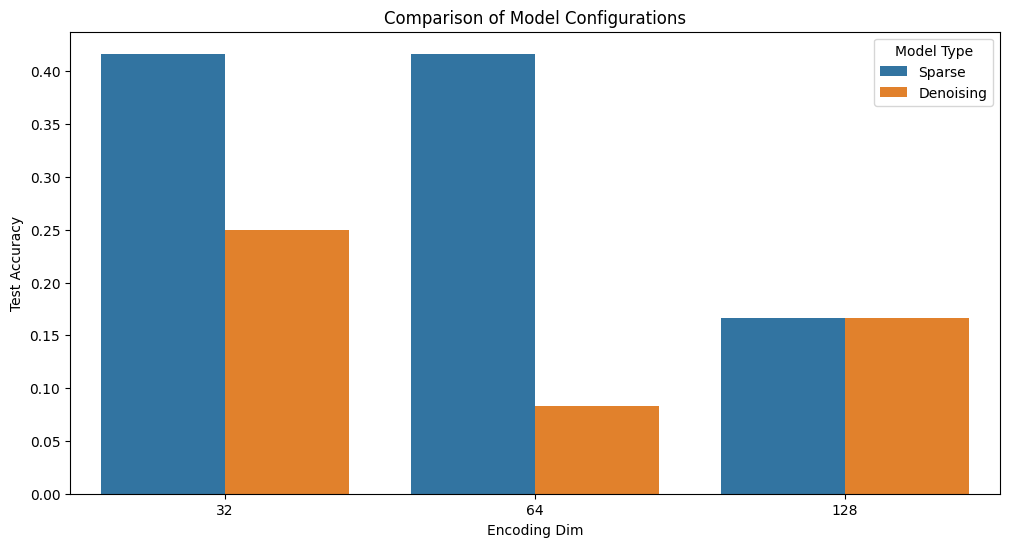


Mejor configuración encontrada:
Tipo de modelo: Sparse
Parámetros: {'encoding_dim': 32, 'sparsity': 1e-05, 'dropout_rate': 0.1}
Accuracy: 0.4167

Reporte de clasificación detallado:
              precision    recall  f1-score   support

           0       0.42      1.00      0.59         5
           1       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2

    accuracy                           0.42        12
   macro avg       0.10      0.25      0.15        12
weighted avg       0.17      0.42      0.25        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
 # Configuración de parámetros
param_combinations = [
    {'encoding_dim': 32, 'sparsity': 1e-5, 'dropout_rate': 0.1},
    {'encoding_dim': 64, 'sparsity': 1e-6, 'dropout_rate': 0.2},
    {'encoding_dim': 128, 'sparsity': 1e-7, 'dropout_rate': 0.3}
]

# 1. Cargar y preprocesar datos
train_df, test_df, label_encoder = load_and_preprocess_data(
    'train.csv',
    'test.csv'
)

# 2. Cargar imágenes
X_train_images, y_train_labels, y_train_encoded = load_images_from_paths(train_df)
X_test_images, y_test_labels, y_test_encoded = load_images_from_paths(test_df)

# 3. Aplanar imágenes
input_dim = X_train_images.shape[1] * X_train_images.shape[2]
X_train_flat = X_train_images.reshape((X_train_images.shape[0], input_dim))
X_test_flat = X_test_images.reshape((X_test_images.shape[0], input_dim))

# 4. Almacenar resultados
all_results = []

# 5. Entrenar y evaluar modelos
for params in param_combinations:
    print(f"\nEvaluando configuración: {params}")

    # Sparse Autoencoder
    print("\nEntrenando Sparse Autoencoder...")
    sparse_ae = build_sparse_autoencoder(
        input_dim=input_dim,
        encoding_dim=params['encoding_dim'],
        sparsity_reg=params['sparsity']
    )

    sparse_ae, sparse_history = train_autoencoder(
        sparse_ae,
        X_train_flat
    )

    sparse_latent_train = get_latent_space(sparse_ae, X_train_flat)
    sparse_latent_test = get_latent_space(sparse_ae, X_test_flat)

    sparse_results = train_and_evaluate_classifier(
        sparse_latent_train,
        sparse_latent_test,
        y_train_encoded,
        y_test_encoded
    )

    sparse_results.update({
        'model_type': 'Sparse',
        'params': params
    })
    all_results.append(sparse_results)

    # Denoising Autoencoder
    print("\nEntrenando Denoising Autoencoder...")
    denoising_ae = build_denoising_autoencoder(
        input_dim=input_dim,
        encoding_dim=params['encoding_dim'],
        dropout_rate=params['dropout_rate']
    )

    denoising_ae, denoising_history = train_autoencoder(
        denoising_ae,
        X_train_flat
    )

    denoising_latent_train = get_latent_space(denoising_ae, X_train_flat)
    denoising_latent_test = get_latent_space(denoising_ae, X_test_flat)

    denoising_results = train_and_evaluate_classifier(
        denoising_latent_train,
        denoising_latent_test,
        y_train_encoded,
        y_test_encoded
    )

    denoising_results.update({
        'model_type': 'Denoising',
        'params': params
    })
    all_results.append(denoising_results)

# 6. Visualizar comparación final
plot_results_comparison(all_results)

# 7. Encontrar mejor configuración
best_result = max(all_results, key=lambda x: x['accuracy'])
print("\nMejor configuración encontrada:")
print(f"Tipo de modelo: {best_result['model_type']}")
print(f"Parámetros: {best_result['params']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print("\nReporte de clasificación detallado:")
print(classification_report(y_test_encoded, best_result['predictions']))

In [4]:
# Mostrar resultados para todas las configuraciones
print("\nResultados para todas las configuraciones:")
print("-" * 80)

for result in all_results:
    print(f"\nTipo de modelo: {result['model_type']}")
    print(f"Parámetros:")
    print(f"  - Dimensión de codificación: {result['params']['encoding_dim']}")
    if result['model_type'] == 'Sparse':
        print(f"  - Regularización de sparsity: {result['params']['sparsity']}")
    else:
        print(f"  - Tasa de dropout: {result['params']['dropout_rate']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("-" * 80)


Resultados para todas las configuraciones:
--------------------------------------------------------------------------------

Tipo de modelo: Sparse
Parámetros:
  - Dimensión de codificación: 32
  - Regularización de sparsity: 1e-05
Accuracy: 0.4167
--------------------------------------------------------------------------------

Tipo de modelo: Denoising
Parámetros:
  - Dimensión de codificación: 32
  - Tasa de dropout: 0.1
Accuracy: 0.2500
--------------------------------------------------------------------------------

Tipo de modelo: Sparse
Parámetros:
  - Dimensión de codificación: 64
  - Regularización de sparsity: 1e-06
Accuracy: 0.4167
--------------------------------------------------------------------------------

Tipo de modelo: Denoising
Parámetros:
  - Dimensión de codificación: 64
  - Tasa de dropout: 0.2
Accuracy: 0.0833
--------------------------------------------------------------------------------

Tipo de modelo: Sparse
Parámetros:
  - Dimensión de codificación: 128
